In [1]:
from exojax.dynamics import rvfunc

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map

import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


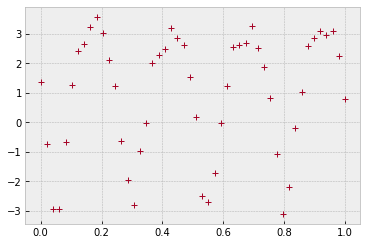

In [3]:
t=np.linspace(0,1.0,50)
T0=0.3
P=0.25
e=0.3
omegaA=np.pi
Ksini=3.0
Vsys=1.0
sigma=0.3
rv=rvfunc.rvf(t,T0,P,e,omegaA,Ksini,Vsys)+np.random.normal(0,sigma,len(t))
plt.plot(t,rv,"+",color="C1")
plt.show()

In [4]:
#probabilistic model using numpyro
def model(t,y):
    #prior                                                                      
    se_sino = numpyro.sample("se_sino",dist.Uniform(-1.0,1.0)) #sqrt(e) sin omega                                                                              
    se_coso = numpyro.sample("se_coso",dist.Uniform(-1.0,1.0)) #sqrt(e) cos omega                                                                              
    # comment: think about this condition 0.0 < e < 1.0                         
    T0 = numpyro.sample("T0",dist.Uniform(0.2,0.4))
    P = numpyro.sample("P",dist.Uniform(0.1,0.3))
    Ksini = numpyro.sample("Ksini",dist.Uniform(0.0,10.0))
    Vsys = numpyro.sample("Vsys",dist.Uniform(0.0,10.0))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    
    e=se_coso**2+se_sino**2
    omegaA=jnp.arctan2(se_sino,se_coso)

    mu=rvfunc.rvf(t,T0,P,e,omegaA,Ksini,Vsys)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [5]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, t=t, y=rv)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 260.00it/s, 15 steps of size 1.77e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     Ksini      2.93      0.06      2.93      2.83      3.02   1406.24      1.00
         P      0.25      0.00      0.25      0.25      0.25   1367.42      1.00
        T0      0.30      0.00      0.30      0.29      0.30    935.91      1.00
      Vsys      0.95      0.04      0.95      0.88      1.02   1376.69      1.00
   se_coso     -0.54      0.02     -0.54     -0.56     -0.51   1131.94      1.00
   se_sino      0.05      0.04      0.05     -0.02      0.11    889.73      1.00
     sigma      0.29      0.03      0.29      0.24      0.34   1263.33      1.00

Number of divergences: 359


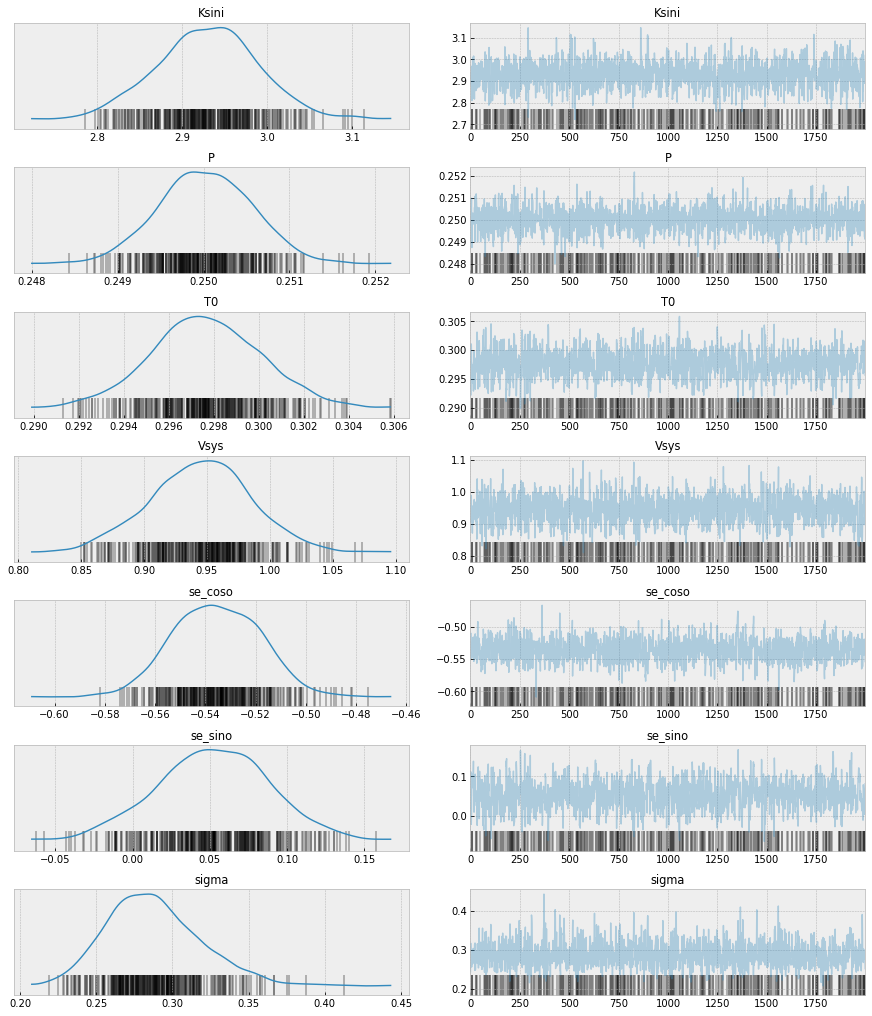

In [6]:
#arviz is superuseful to check chains
arviz.plot_trace(mcmc, var_names=["Ksini","P","T0","Vsys","se_coso","se_sino","sigma"])
plt.show()

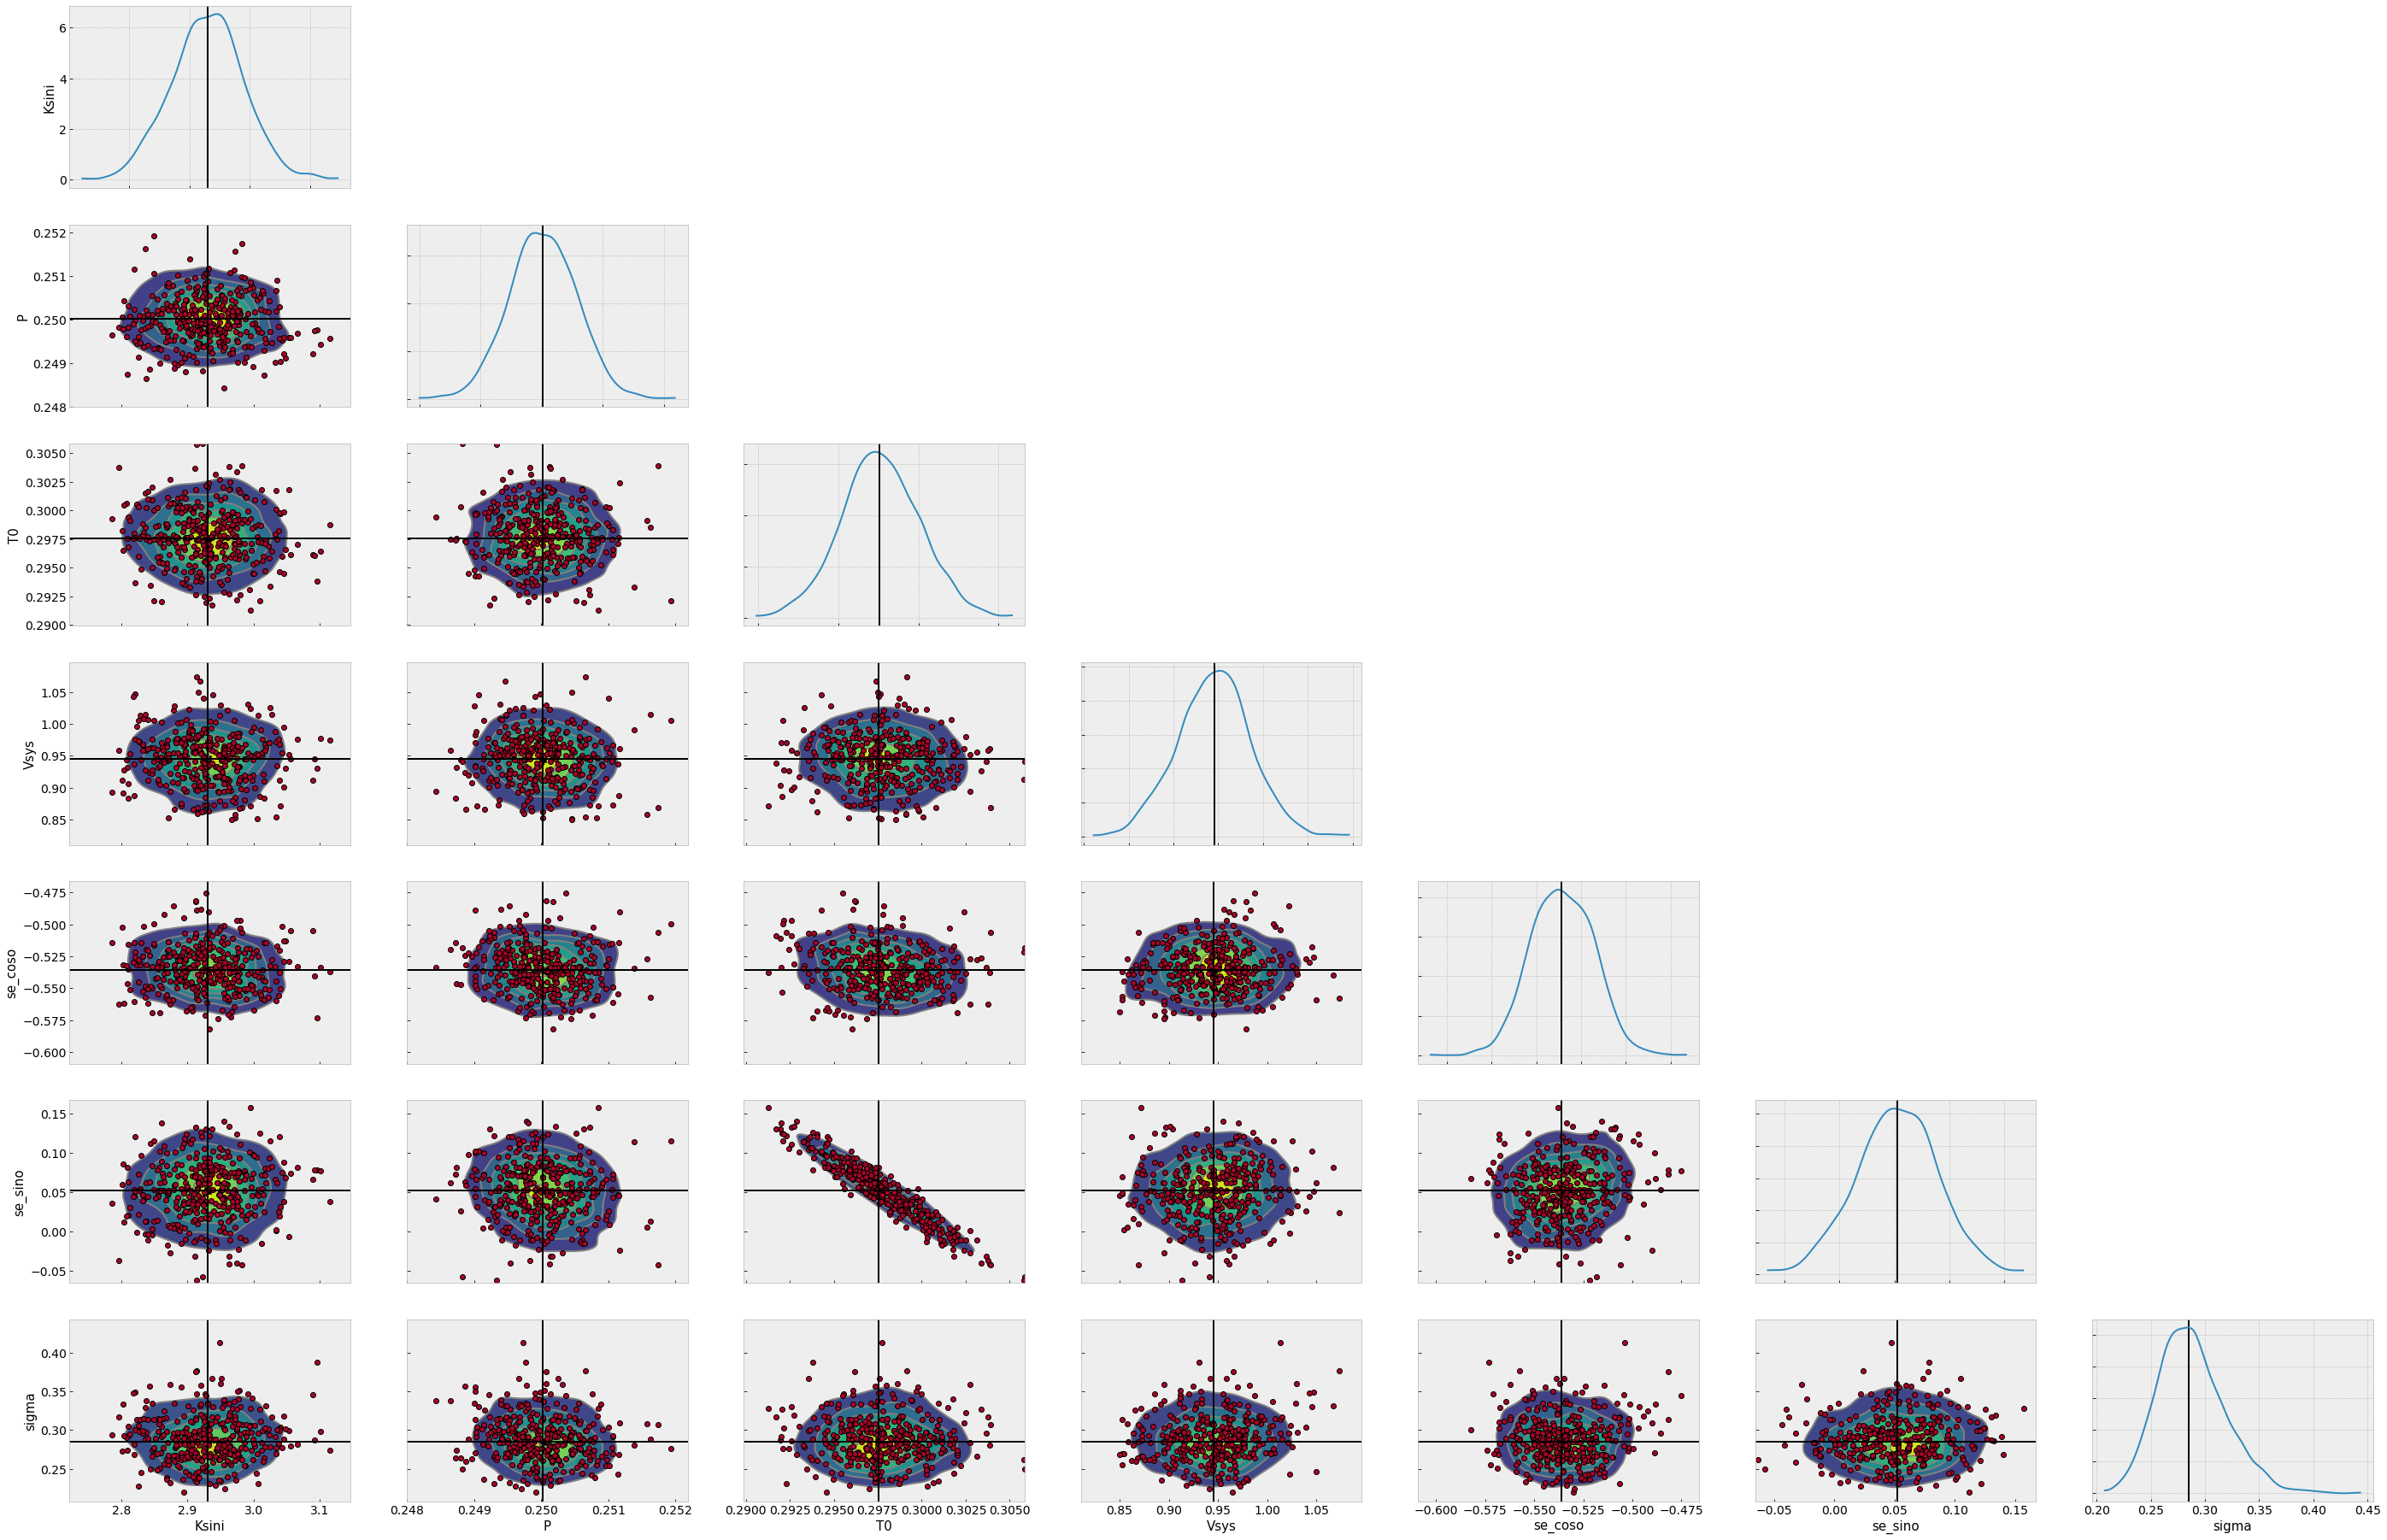

In [12]:
#cool and flexible corner plot in arviz. You can also try kind='hexbin' instead of 'kde' for instance.

arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=True,marginals=True,point_estimate="median") #if you are brave
#arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=True)
plt.show()

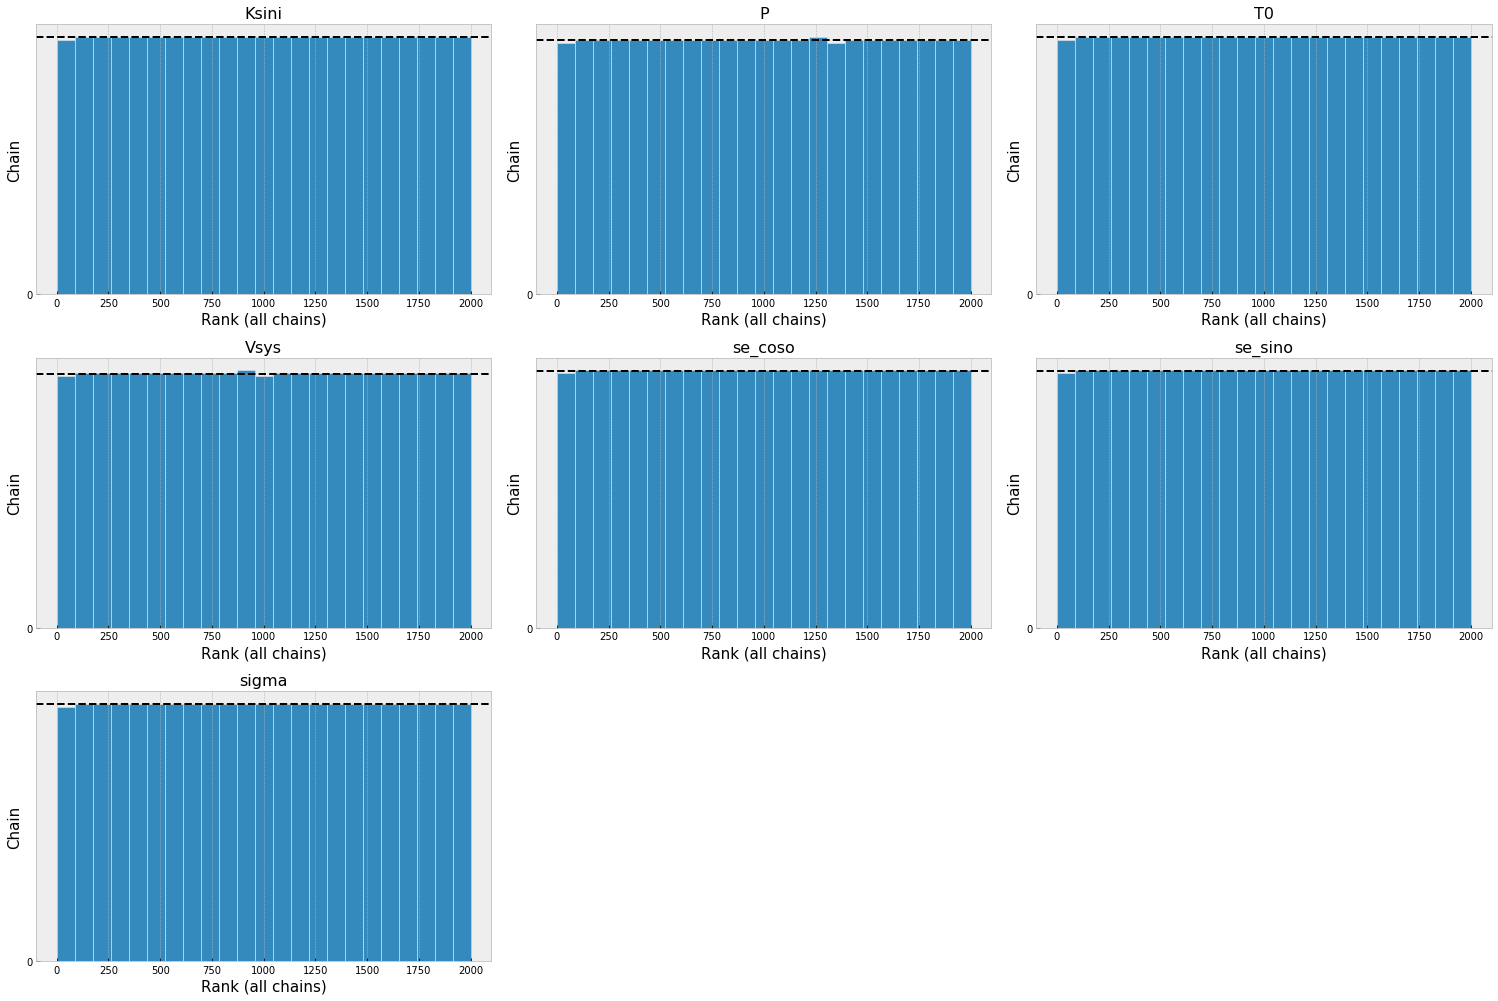

In [9]:
# further check of chain
arviz.plot_rank(arviz.from_numpyro(mcmc))
plt.show()

In [10]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
t_ = jnp.linspace(-0.1,1.1,1000)
predictions = pred(rng_key_,t=t_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

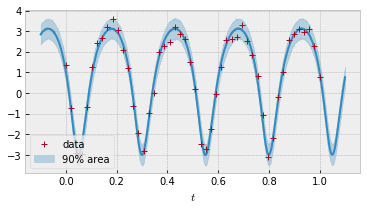

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t_,median_mu,color="C0")
ax.plot(t,rv,"+",color="C1",label="data")
ax.fill_between(t_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$t$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_rv.png")
plt.show()